# Rupaul's Drag Race Machine

In [18]:
#%matplotlib inline

import pandas as pd
import numpy as np
import math, random
from scipy.stats import rankdata, kendalltau
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

theData = pd.read_csv("dragrace.csv")
theData= theData.fillna(0)
#theData.iloc[1:10,:]

In [19]:
queens = theData.groupby('Name').max()
queens = queens.reset_index(drop=False)
#queens.iloc[1:10,:]

In [20]:
# create a function to scale the data for us
def scaleQueens(df):
    """Scale Age, Wins, Highs, Lows, and Lipsyncs in feature data frames"""
    df = df.copy(deep=True)
    df['Age'] = scale(df['Age'])
    df['Wins'] = scale(df['Wins'])
    df['Highs'] = scale(df['Highs'])
    df['Lows'] = scale(df['Lows'])
    df['Lipsyncs'] = scale(df['Lipsyncs'])
    df['Season'] = df['Season']/8
    return df

In [21]:
def compareRanks(x,y):
    x=np.asarray(x)
    y=np.asarray(y)
    numRanks = np.append(x,y).max()
    actual=np.sum(np.square(x-y))
    worst=np.sum(np.square(np.sort(x)-np.sort(x)[::-1]))
    return 1-2*(actual/worst)

In [22]:
def createPD(s,queens,yfitpd):
    season = queens.loc[queens.Season==s,['Name','Place']]
    seasonpred = yfitpd.loc[queens.Season==s]
    season['Predicted'] = seasonpred
    season['Predicted'] = rankdata(season.Predicted,method='min')
    season = season.sort_values('Place')
    return season

In [23]:
def predictSeason(season,model,queens,scaled=False):
    Xtrain = queens.loc[queens.Season!=season,['Age','PuertoRico','PlusSize','Wins','Highs','Lows','Lipsyncs','Season']]
    Xtest = queens.loc[queens.Season==season,['Age','PuertoRico','PlusSize','Wins','Highs','Lows','Lipsyncs','Season']]
    ytrain = queens.loc[queens.Season!=season,'Place']
    if scaled:
        Xtrain = scaleQueens(Xtrain)
        Xtest = scaleQueens(Xtest)
    model.fit(Xtrain,ytrain)
    yfit = model.predict(Xtest)
    pddf = queens.loc[queens.Season==season,['Name','Place']]
    pddf['Predicted'] = rankdata(yfit,method='min')
    return pddf

In [24]:

class neural_network:
    """Defines a neural network, along with attributes for fitting and predicting the network"""
    def __init__(self,size):
        random.seed(0)
        self.network = []
        for i in range(1,len(size)):
            self.network.append([[random.random() for __ in range(size[i-1] + 1)] for __ in range(size[i])])
    
    def sigmoid(self,t): 
        return 1 / (1 + math.exp(-t))
    
    def neuron_output(self,weights, inputs):   #This is a simpler representation; weights for input plus one extra (bias)
        return self.sigmoid(np.dot(weights, inputs))
    
    def feed_forward(self,input_vector):
        outputs = []

        for layer in self.network: #Remember the neural network is given as a list of "layers" which have neurons in them

            input_with_bias = input_vector + [1]          # add a bias input (this just allos us to use a dot product)
            output = [self.neuron_output(neuron, input_with_bias) # compute the output
                      for neuron in layer]                   # for this layer
            outputs.append(output)                           # and remember it

            # the input to the next layer is the output of this one
            input_vector = output

        return outputs
    
    def predict(self,X):
        X = scaleQueens(X)
        predictedY = []
        X = X.values.tolist()
        for i, input in enumerate(X):
            outputs = self.feed_forward(input)[-1]
            predictedY.append(outputs)
        predictedPlace = [a.index(max(a)) for a in predictedY]
        return predictedPlace
    
    
    def convertY(self,Y):
        yNN = [[1 if i == (j-1) else 0 for i in range(0,len(Y)-1)]
               for j in Y ]
        return(yNN)
    
    # define the back-propagation that allows the network to learn
    def backpropagate(self, input_vector, target):
        hidden_outputs, outputs = self.feed_forward(input_vector)

        # the output * (1 - output) is from the derivative of sigmoid
        output_deltas = [output * (1 - output) * (output - target[i])
                         for i, output in enumerate(outputs)]

        # adjust weights for output layer (network[-1])
        for i, output_neuron in enumerate(self.network[-1]):
            for j, hidden_output in enumerate(hidden_outputs + [1]):
                output_neuron[j] -= output_deltas[i] * hidden_output

        # back-propagate errors to hidden layer
        hidden_deltas = [hidden_output * (1 - hidden_output) * 
                          np.dot(output_deltas, [n[i] for n in self.network[-1]]) 
                         for i, hidden_output in enumerate(hidden_outputs)]

        # adjust weights for hidden layer (network[0])
        for i, hidden_neuron in enumerate(self.network[0]):
            for j, input in enumerate(input_vector + [1]):
                hidden_neuron[j] -= hidden_deltas[i] * input
    
    def fit(self,features,targets,times=10000):
        features = scaleQueens(features)
        targets = self.convertY(targets)
        features = features.values.tolist()
        for i in range(times):
            for X, Y in zip(features, targets):
                self.backpropagate(X,Y)
        
        
        

In [25]:
Xtrain = queens.loc[:,['Age','PuertoRico','PlusSize','Wins','Highs','Lows','Lipsyncs','Season']]
Xtrain.reset_index(drop=True)
ytrain = queens.loc[:,'Place']
ytrain.reset_index(drop=True)

season7 = queens.loc[queens.Season==7,['Name','Place']]
season7.columns = ['Name','Actual']
season7 = season7.reset_index(drop=True)
season8 = queens.loc[queens.Season==8,['Name','Place']]
season8.columns = ['Name','Actual']
season8 = season8.reset_index(drop=True)

In [26]:
XtrainS = scaleQueens(Xtrain)

/Users/thomas/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [27]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

svc_model = SVC(kernel='rbf',gamma=0.01,C=10)
gnb_model = GaussianNB()
rfc_model = RandomForestClassifier(n_estimators=100, random_state=0)
rfr_model = RandomForestRegressor(200,random_state=24601)
nn_model = neural_network([8,5,14])

In [28]:
the_models = [gnb_model,rfc_model,rfr_model,nn_model]
model_names = ["GNB","RFC","RFR","NN"]
for i in range(1,9):
    season = predictSeason(i,svc_model,queens,True)
    season['Season'] = i
    season['Model'] = 'SVC'
    rank_score = compareRanks(season.Place,season.Predicted)
    rsdf = pd.DataFrame({'Season': [i], 'Value': [rank_score], 'Model': ['SVM']})
    if i == 1:
        pred_df = season
        rank_scores = rsdf.copy(deep=True)
    else:
        pred_df = pred_df.append(season)
        rank_scores = rank_scores.append(rsdf)
n = 0
for model in the_models:
    for i in range(1,9):
        season = predictSeason(i,model,queens)
        season['Season'] = i
        season['Model'] = model_names[n]
        pred_df = pred_df.append(season)
        rank_score = compareRanks(season.Place,season.Predicted)
        rsdf = pd.DataFrame({'Season': [i], 'Value': [rank_score], 'Model': [model_names[n]]})
        rank_scores = rank_scores.append(rsdf)
    n += 1


/Users/thomas/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Users/thomas/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Users/thomas/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Users/thomas/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Users/thomas/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConv

In [29]:
season = pred_df.pivot_table(index=('Name','Place','Season'),columns='Model').sortlevel(['Season','Place'])
season.to_csv('PredictedSeasons.csv')

In [30]:
rank_table = rank_scores.pivot_table(index=('Season'),columns='Model')
rank_table.to_csv('RankScores.csv')

In [31]:
rank_table.columns = rank_table.columns.droplevel()

In [32]:
rank_table

Model,GNB,NN,RFC,RFR,SVM
Season,,,,,
1,0.800000,0.783333,0.725000,0.716667,0.866667
2,0.755245,0.825175,0.723776,0.909091,0.888112
3,0.898352,0.785714,0.936813,0.873626,0.914835
4,0.510989,0.912088,0.587912,0.846154,0.826923
5,0.685714,0.881319,0.762637,0.894505,0.890110
6,0.802198,0.971429,0.901099,0.947253,0.938462
7,0.648352,0.945055,0.771429,0.843956,0.868132
8,0.932075,0.898113,0.867925,0.898113,0.856604


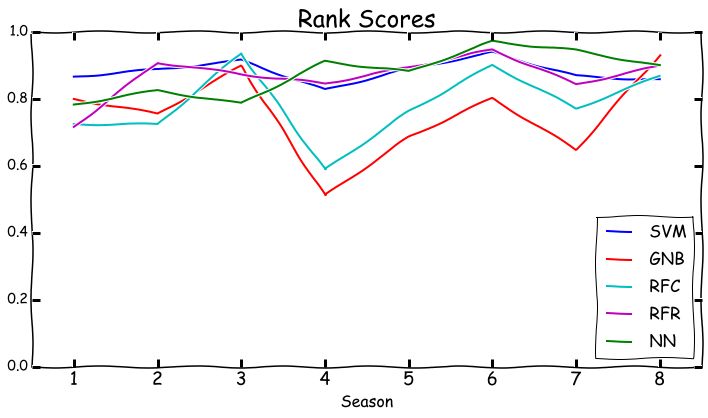

In [37]:
%matplotlib inline
import matplotlib
matplotlib.rc('xtick',labelsize=18)
plt.xkcd()

plt.figure(figsize=(12,6))
plt.plot(rank_table.SVM, label="SVM")
plt.plot(rank_table.GNB, label="GNB")
plt.plot(rank_table.RFC, label="RFC")
plt.plot(rank_table.RFR, label="RFR")
plt.plot(rank_table.NN, 'g-', label="NN")
plt.axis([0.5,8.5,0,1])
plt.title("Rank Scores",fontsize=24)
plt.legend(loc='lower right')
plt.xlabel("Season",fontsize=16)

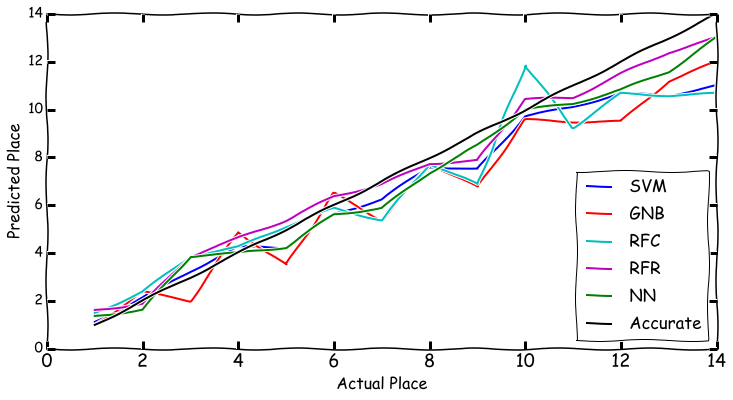

In [38]:
accurate_place = pred_df.pivot_table(index='Place',columns='Model',values='Predicted',aggfunc=np.mean)

plt.figure(figsize=(12,6))
plt.plot(accurate_place.SVC, label="SVM")
plt.plot(accurate_place.GNB, label="GNB")
plt.plot(accurate_place.RFC, label="RFC")
plt.plot(accurate_place.RFR, label="RFR")
plt.plot(accurate_place.NN, 'g-', label="NN")
plt.plot(range(1,15),range(1,15), 'k-', label="Accurate")
#plt.axis([0.5,8.5,0,1])

plt.legend(loc='lower right')
plt.xlabel("Actual Place",fontsize=16)
plt.ylabel("Predicted Place",fontsize=16)